In [1]:
from utils import get_app_logger

logger = get_app_logger('nb')

In [2]:
env ROOT_CFG_DIR=/Users/aukermaa/

env: ROOT_CFG_DIR=/Users/aukermaa/


In [8]:
from utils import get_config
config = get_config()

[2022-05-06 16:48:37,203] [utils] INFO: Loaded config: ['alpaca', 'firehose', 'fmp', 'dremio']


In [9]:
from connector import DremioDataframeConnector
dremio = DremioDataframeConnector(
    scheme = 'grpc+tcp',
    hostname = config['dremio']['URL'],
    flightport =  config['dremio']['PORT'],
    dremio_user = config['dremio']['USERNAME'],
    dremio_password = config['dremio']['PASSWORD'],
    connection_args = {})

In [10]:
# Get first week day's trading in march

In [12]:
SOURCE_DATA = dremio.get_table("""SELECT * FROM "@auker".MB_DATA 
    WHERE bar_time > '2022-02-27' AND bar_time < '2022-03-05' """)

[INFO] Query:  SELECT * FROM "@auker".MB_DATA where bar_time > '2022-02-27' and bar_time < '2022-03-05' 


In [18]:
SOURCE_DATA = SOURCE_DATA.reset_index().drop_duplicates(subset=['bar_time', 'ticker']).set_index(['ticker', 'bar_time'])
SOURCE_DATA

,,open_price,high_price,low_price,close_price,volume,year,month,day,hour,first_seen_time
ticker,bar_time,,,,,,,,,,
INDO,2022-02-28 13:24:00,14.750000,14.750000,14.750000,14.750000,962.0,2022,02,28,13,2022-02-28 13:25:00.026
ALF,2022-02-28 13:24:00,2.410000,2.410000,2.410000,2.410000,300.0,2022,02,28,13,2022-02-28 13:25:00.022
REGI,2022-02-28 13:24:00,60.560001,60.560001,60.560001,60.560001,100.0,2022,02,28,13,2022-02-28 13:25:00.024
IMPP,2022-02-28 13:24:00,2.350000,2.350000,2.340000,2.340000,785.0,2022,02,28,13,2022-02-28 13:25:00.028
ASO,2022-02-28 13:24:00,32.209999,32.209999,32.209999,32.209999,700.0,2022,02,28,13,2022-02-28 13:25:00.189
...,...,...,...,...,...,...,...,...,...,...,...
HDB,2022-03-04 21:46:00,57.450001,57.450001,57.450001,57.450001,200.0,2022,03,04,21,2022-03-04 21:47:00.770
BCEL,2022-03-04 21:47:00,4.650000,4.690000,4.650000,4.650000,610.0,2022,03,04,21,2022-03-04 21:48:00.005
INDO,2022-03-04 21:47:00,39.700001,40.380001,39.700001,40.380001,413.0,2022,03,04,21,2022-03-04 21:48:00.005


ticker
AAAU_on_2022-3-1        7
AAC.U_on_2022-3-1       2
AAC.WS_on_2022-3-1      2
AAC_on_2022-3-1         5
AADI_on_2022-3-1       14
                     ... 
ZYME_on_2022-3-1       80
ZYNE_on_2022-3-1       28
ZYXI_on_2022-3-1       59
ZY_on_2022-3-1         48
Z_on_2022-3-1         249
Name: first_seen_time, Length: 7885, dtype: int64


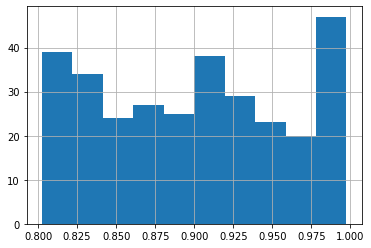

In [19]:
import pandas as pd
import numpy as np
from datetime import datetime

class DaysTrading:
    def __init__(self, df, year, month, day):
        df = df.copy()
        
        self.t_start = pd.Timestamp(datetime(year, month, day))
        self.t_end   = pd.Timestamp(datetime(year, month, day + 1))
        
        self.buy_time   = pd.Timestamp(datetime(year, month, day, 14, 45, 0))
        self.stop_time  = pd.Timestamp(datetime(year, month, day, 14, 50, 0))
        self.premarket_time  = pd.Timestamp(datetime(year, month, day, 14, 30, 0))
        self.aftermarket_time  = pd.Timestamp(datetime(year, month, day, 21, 0, 0))
                               
        self.data = self.get_slice_by_time(df, self.t_end, self.t_start)
        
        self.index_string = '{}' + f'_on_{year}-{month}-{day}'
        
        self.tickers = self.data.index.get_level_values('ticker').unique()
        
        self.data = self.data.rename(self.index_string.format, level='ticker')

        self.features = {}
        
        self.labelize()
        self.fx_gate_performance()
        self.fx_premarket_activity()
        self.fx_online_percentage()
#         self.fx_sector()
        
    def get_slice_by_time(self, df, t1, t0=None):
        df = df.loc[df.index.get_level_values('bar_time') < t1]
        if t0 is not None: df = df.loc[df.index.get_level_values('bar_time') >= t0]
        return df
    
    def get(self): return self.data.copy()
    
    def labelize(self):    
        """ Returns high values reached greater than 2.5% the open price of the next tick """
        df = self.get()

        after_prediction_open = df.loc[df.first_seen_time > self.buy_time, 'open_price'] # We buy at the first tick after T_buy
        after_prediction_high = df.loc[df.first_seen_time > self.stop_time, 'high_price'] # We buy at the first tick after T_buy

        first_bar = after_prediction_open.groupby('ticker').first()

        self.labels = after_prediction_high.div(first_bar, level='ticker', axis='index') \
            .groupby('ticker')\
            .max()\
            .ge(1.05)

        self.high_after_d0 = after_prediction_high
        
        self.after_d0 = df.loc[df.first_seen_time > self.stop_time]
        
    def fx_online_percentage(self):
        df = self.get()
        
        trading_hours_df = df.loc[(df.first_seen_time > self.premarket_time) & (df.first_seen_time < self.aftermarket_time)]
        print (trading_hours_df['first_seen_time'].groupby('ticker').count())
        
        df_online_pct = trading_hours_df['first_seen_time'].groupby('ticker').count().rename('online_pct') / 390 
        df_online_pct = df_online_pct[df_online_pct > 0.8]
        df_online_pct.hist()
        
        self.pre_filter_tickers = df_online_pct.index
            

        
    def fx_gate_performance(self):
        """ Returns first 5 mins """
        df = self.get()

        after_premarket_open = df.loc[df.first_seen_time >= self.premarket_time, 'open_price']
        before_buy_high      = df.loc[df.first_seen_time <  self.buy_time, 'high_price']

        first_bar = after_premarket_open.groupby('ticker').first()

        ticker_group = before_buy_high.div(first_bar, level='ticker', axis='index').groupby('ticker')

        out = ticker_group.agg(['mean', 'count', 'max', 'min', 'std', 'skew']).add_prefix('gate_performance_')
        self.features['gate'] = out      
    
    def fx_premarket_activity(self):
        """ Returns online tickes in premarket """
        df = self.get()

        premarket_volume = df.loc[df.first_seen_time < self.premarket_time, 'volume'] # We buy at the first tick after T_buy

        counts = premarket_volume.groupby('ticker').count().rename('count_value')

        counts_present = counts.ge(0).rename('count>0')

        self.features['premarket'] = pd.concat((counts, counts_present), axis=1).add_prefix('premarket_')
        
    def fx_sector(self):
        self.tickers
        
        df = pd.read_parquet('sector.parquet')
        
        print (len(self.tickers))
        
        df = df.loc[df.index.intersection(self.tickers)]
        
        encoder = OneHotEncoder(categories=[df['industryTitle'].value_counts().head(5).index], handle_unknown='ignore')
        out  =  encoder.fit_transform(df[['industryTitle']]).toarray()
        sector_features = pd.DataFrame(out, index=df.index, columns=encoder.categories_[0]).rename(self.index_string.format)
        
        self.features['sector'] = sector_features
        
        
    def get_data(self):
        X_aligned = pd.concat([df for _, df in self.features.items()], axis=1)
        
        X_aligned = X_aligned.loc[self.pre_filter_tickers]
        print (X_aligned)
        y_aligned = self.labels.reindex(X_aligned.index).fillna(0).astype(float)

        data = X_aligned.join(y_aligned.rename('label'))
        return data

dt_0 = DaysTrading(SOURCE_DATA, 2022, 3, 1)

In [30]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [31]:
def fit_test(pipe, X, y, train_px, valid_px):
        
    pipe.fit(X.loc[train_px], y.loc[train_px])
        
    df_coef = pd.DataFrame([pipe.named_steps['clf'].coef_[0], np.sign(pipe.named_steps['clf'].coef_[0])], columns=pipe.named_steps['interaction'].get_feature_names(input_features=X.columns), index=['coef', 'sign'])

    valid_scores = pipe.predict_proba(X.loc[valid_px])[:,1]
    valid_labels = y.loc[valid_px].values
        
    return valid_scores, valid_labels, df_coef

def generate_auc_plot(labels, scores, title='Receiver operating characteristic', merge=True, average=True, figsize=(6,6), max_folds=10, names=None, extra_opts=None):
    """ Makes the nice fold-wise, average, and merged AUROC plots
    labels: a list of label arrays
    scores: a list of score arrays
    title: A title for the plot
    figsize: Figure size
    merge: Whether to merge the list of labels, scores in CV fashion (e.g. set to false for subsampling)
    max_folds: Maximum number of folds to show
    """
    if extra_opts is None: extra_opts = {}
        
    plt.figure(figsize=figsize)
    tprs = []
    aucs = []
    
    l_v_scores =[]
    l_v_labels = []

    mean_fpr = np.linspace(0, 1, 100)

    for i, (fold_labels, fold_scores) in enumerate(zip(labels, scores)):
        fpr, tpr, thresholds = roc_curve(fold_labels, fold_scores)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        
        if names is not None:
            label = '%s (AUC = %0.2f)' % (names[i], roc_auc)
            opts = {'alpha':1.0, 'lw':1}
            opts.update(extra_opts.get(names[i], {}))
        else:
            label = 'Fold %d (AUC = %0.2f)' % (i + 1, roc_auc)
            opts = {'alpha':0.5, 'lw':1}
            alpha = 0.5
            
        if max_folds is None or i < max_folds: 
            plt.plot(fpr, tpr, label=label, **opts)
        print ('Fold %d (AUC = %0.2f), N=%d' % (i + 1, roc_auc, len(fold_labels)))
        
        if merge:
            l_v_scores.extend(fold_scores)
            l_v_labels.extend(fold_labels)

    if merge:
        fpr, tpr, thresholds = roc_curve(l_v_labels, l_v_scores)
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, color='k', label='Merged ROC (AUC = %0.2f)' % (roc_auc))

    if average: 
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

ticker
AAAU_on_2022-3-1        7
AAC.U_on_2022-3-1       2
AAC.WS_on_2022-3-1      2
AAC_on_2022-3-1         5
AADI_on_2022-3-1       14
                     ... 
ZYME_on_2022-3-1       80
ZYNE_on_2022-3-1       28
ZYXI_on_2022-3-1       59
ZY_on_2022-3-1         48
Z_on_2022-3-1         249
Name: first_seen_time, Length: 7885, dtype: int64
                  gate_performance_mean  gate_performance_count  \
ticker                                                            
AAL_on_2022-3-1                0.992946                      14   
AAPL_on_2022-3-1               1.008043                      14   
AA_on_2022-3-1                 1.037087                      14   
ABBV_on_2022-3-1               1.004011                      12   
ABNB_on_2022-3-1               1.006718                      13   
...                                 ...                     ...   
XLU_on_2022-3-1                1.005522                      11   
XLV_on_2022-3-1                1.006021               

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Making plot...
Fold 1 (AUC = 0.48), N=31
Fold 2 (AUC = 0.81), N=31
Fold 3 (AUC = 0.92), N=31
Fold 4 (AUC = 0.87), N=31
Fold 5 (AUC = 0.80), N=31
Fold 6 (AUC = nan), N=31
Fold 7 (AUC = 0.82), N=30
Fold 8 (AUC = 0.73), N=30
Fold 9 (AUC = 0.79), N=30
Fold 10 (AUC = nan), N=30


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


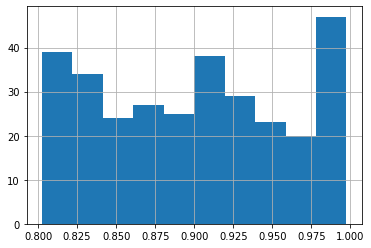

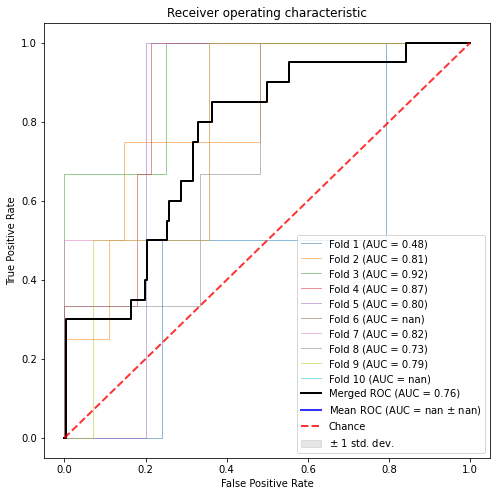

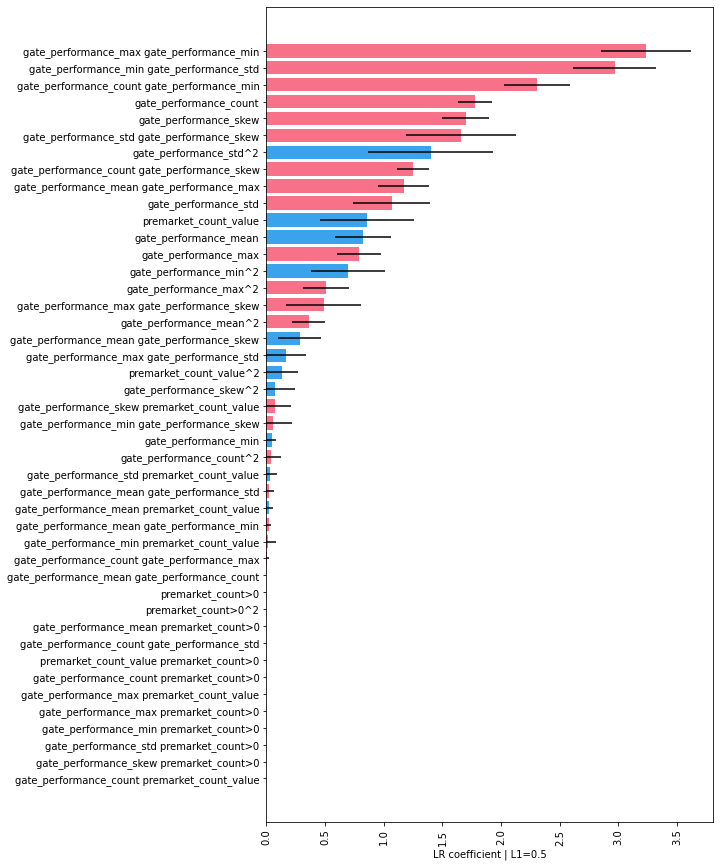

In [32]:
dt_0 = DaysTrading(SOURCE_DATA, 2022, 3, 1)

data = dt_0.get_data()

kf = KFold(n_splits=10, random_state=0, shuffle=True)

l_fold_scores = []
l_fold_labels = []

print ("n_tickers = ", len(data.index))
    
df_coef_cln = pd.DataFrame()
for fold, (train, test) in enumerate(list(kf.split(data.index))):

    train_px = data.index[train]
    valid_px = data.index[test]
    
    pipe = Pipeline([
        ('scaler', MinMaxScaler()), 
        ('imputer', SimpleImputer()), 
        ('interaction', PolynomialFeatures(2, interaction_only=False, include_bias=False)),
#         ('nystroem', Nystroem(kernel="poly", degree=2, n_components=100, random_state=0)),
        ('clf', LogisticRegression(penalty='elasticnet', max_iter=500, solver='saga', l1_ratio=0.5, C=10))
    ])

        
    check_scores, check_labels, df_coef = fit_test(pipe, data.drop(columns=['label']), data['label'], train_px, valid_px)
    
    df_coef_cln = pd.concat([df_coef_cln, df_coef])
    
    l_fold_scores.append(check_scores)
    l_fold_labels.append(check_labels)
    
        
print ("Making plot...")
generate_auc_plot(l_fold_labels, l_fold_scores, max_folds=10, figsize=(8,8))
try:
    fx_importance = df_coef_cln.loc['coef'].T.mean(axis=1).abs().sort_values(ascending=True)
    fx_error = 2*df_coef_cln.loc['coef'].T.loc[fx_importance.index].sem(axis=1)
    fx_sign = -np.sign(df_coef_cln.loc['coef'].T.loc[fx_importance.index].mean(axis=1))
        
    plt.figure(figsize=(8,15))
    plt.barh(fx_importance.index, fx_importance, xerr=fx_error, color = [sns.color_palette("husl", 3)[int(i)] for i in fx_sign.values + 1])
    plt.xlabel("LR coefficient | L1=0.5")
    ticks = plt.xticks(rotation=90)
    plt.xlim(0)
except Exception as err: print (err)

plt.savefig('coef.pdf', bbox_inches='tight')

In [33]:
# Wow, lets look at an out-of sample test (next day)

ticker
AAAU_on_2022-3-3       3
AAC.U_on_2022-3-3      1
AACG_on_2022-3-3       1
AAC_on_2022-3-3       11
AADI_on_2022-3-3      33
                    ... 
ZYME_on_2022-3-3     143
ZYNE_on_2022-3-3      16
ZYXI_on_2022-3-3      62
ZY_on_2022-3-3        35
Z_on_2022-3-3        288
Name: first_seen_time, Length: 7641, dtype: int64
                  gate_performance_mean  gate_performance_count  \
ticker                                                            
AAL_on_2022-3-3                1.008466                      13   
AAPL_on_2022-3-3               1.003686                      14   
AA_on_2022-3-3                 1.005735                      13   
ABT_on_2022-3-3                1.000408                      14   
ADM_on_2022-3-3                0.999887                       6   
...                                 ...                     ...   
XOM_on_2022-3-3                0.998206                      14   
XPEV_on_2022-3-3               1.001537                      14  

,score
ticker,
AAL_on_2022-3-3,0.231619
AAPL_on_2022-3-3,0.022587
AA_on_2022-3-3,0.083942
ABT_on_2022-3-3,0.018587
ADM_on_2022-3-3,0.026898
...,...
XOM_on_2022-3-3,0.027534
XPEV_on_2022-3-3,0.128070
X_on_2022-3-3,0.089083


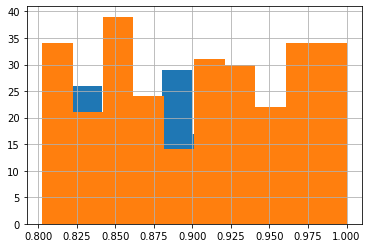

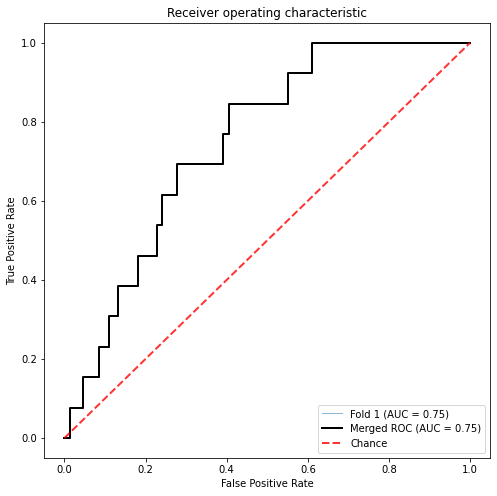

In [34]:
dt_0 = DaysTrading(SOURCE_DATA, 2022, 3, 3).get_data()
dt_1 = DaysTrading(SOURCE_DATA, 2022, 3, 2).get_data()

data = pd.concat([dt_0, dt_1])

l_fold_scores = []
l_fold_labels = []

print ("n_tickers = ", len(data.index))
    
df_coef_cln = pd.DataFrame()

train_px = dt_1.index
valid_px = dt_0.index

pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('imputer', SimpleImputer()), 
    ('interaction', PolynomialFeatures(2, interaction_only=False, include_bias=False)),
    ('clf', LogisticRegression(penalty='elasticnet', max_iter=500, solver='saga', l1_ratio=0.5, C=10))
])


check_scores, check_labels, df_coef = fit_test(pipe, data.drop(columns=['label']), data['label'], train_px, valid_px)

df_coef_cln = pd.concat([df_coef_cln, df_coef])

l_fold_scores.append(check_scores)
l_fold_labels.append(check_labels)
    
        
print ("Making plot...")
generate_auc_plot(l_fold_labels, l_fold_scores, max_folds=10, figsize=(8,8), average=False)
try:
    fx_importance = df_coef_cln.loc['coef'].T.mean(axis=1).abs().sort_values(ascending=True)
    fx_error = 2*df_coef_cln.loc['coef'].T.loc[fx_importance.index].sem(axis=1)
    fx_sign = -np.sign(df_coef_cln.loc['coef'].T.loc[fx_importance.index].mean(axis=1))
        
    plt.figure(figsize=(8,15))
    plt.barh(fx_importance.index, fx_importance, xerr=fx_error, color = [sns.color_palette("husl", 3)[int(i)] for i in fx_sign.values + 1])
    plt.xlabel("LR coefficient | L1=0.5")
    ticks = plt.xticks(rotation=90)
    plt.xlim(0)
except Exception as err: print (err)
    
df_preds = pd.DataFrame(check_scores,  index=valid_px,  columns=['score'])

df_preds

In [36]:
# Lets see how they actually do...

ticker
AAAU_on_2022-3-3       3
AAC.U_on_2022-3-3      1
AACG_on_2022-3-3       1
AAC_on_2022-3-3       11
AADI_on_2022-3-3      33
                    ... 
ZYME_on_2022-3-3     143
ZYNE_on_2022-3-3      16
ZYXI_on_2022-3-3      62
ZY_on_2022-3-3        35
Z_on_2022-3-3        288
Name: first_seen_time, Length: 7641, dtype: int64
0.12


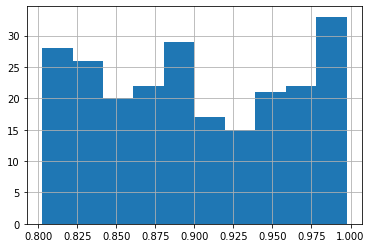

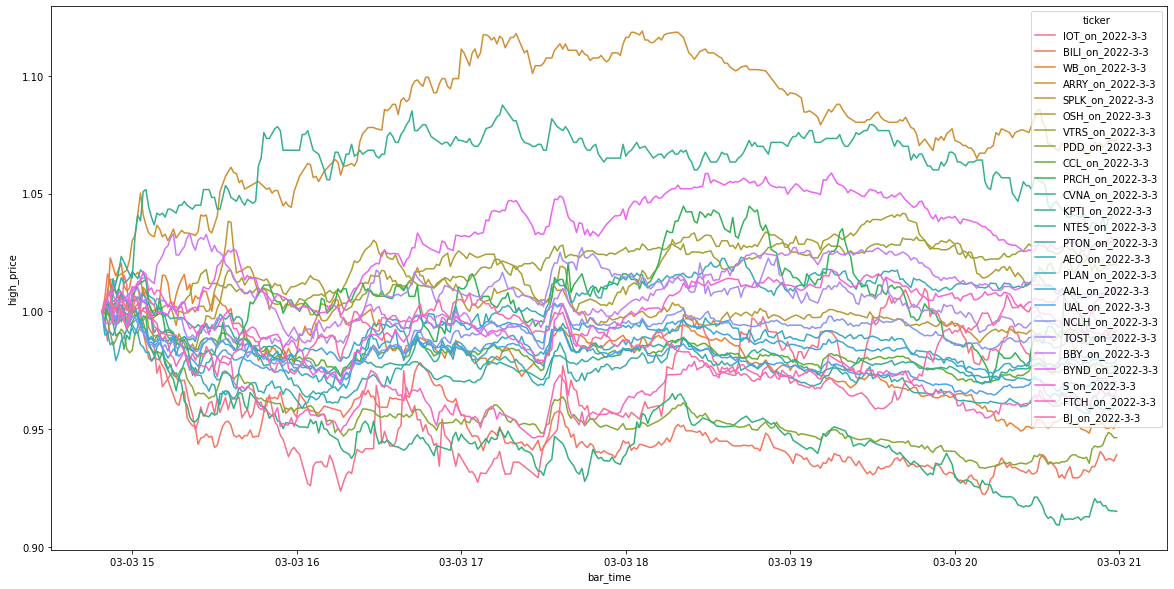

In [35]:
best_10 = df_preds['score'].sort_values(ascending=False).head(25).index

df = DaysTrading(SOURCE_DATA, 2022, 3, 3).high_after_d0.loc[best_10]

plt.figure(figsize=(20,10))

max_vals = df.groupby(by='ticker').first()

close_norm = df.div(max_vals, level='ticker', axis='index')

print (close_norm.groupby('ticker').max().ge(1.05).mean())
close_mean = close_norm.groupby(by='bar_time').agg(np.mean)

sns.lineplot(data=close_norm.reset_index(), x='bar_time', y='high_price', hue='ticker')
plt.show()